In [1]:
import sys
sys.path.append('../')
import pandas as pd 
import numpy as np 
import ta
from backtester import *

In [2]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [3]:
data['cci'] = ta.trend.cci(high=data['high'], low=data['low'], close=data['close'], window=50, fillna=False)
data.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

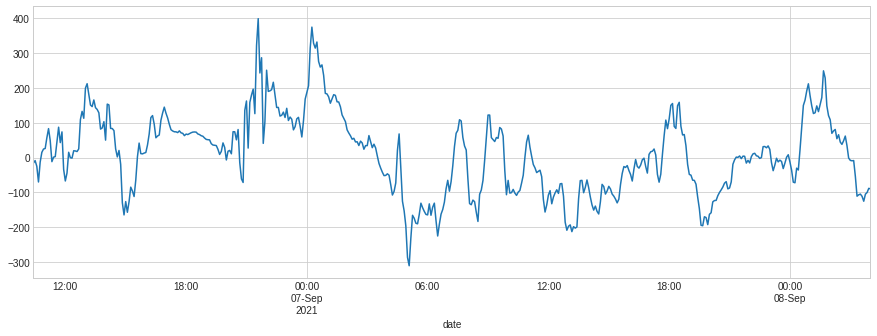

In [4]:
data['cci'].iloc[-500:].plot(figsize=(15,5))

In [5]:
# strategy --> overbought/sold
# cci > 200 --> sell
# cci < -200 --> buy
# else NA
# then ffill
data['cci_signal'] = np.where(data['cci'] > 200, -1,
                              np.where(data['cci'] < -200, 1, np.nan))
data['cci_signal'] = data['cci_signal'].ffill().fillna(0)

In [6]:
print(data['cci_signal'].value_counts())
print("-"*50)
print(data['cci_signal'].diff(1).apply(np.abs).value_counts())

-1.0    5243
 1.0    4676
 0.0      32
Name: cci_signal, dtype: int64
--------------------------------------------------
0.0    9865
2.0      84
1.0       1
Name: cci_signal, dtype: int64


In [7]:
backtest = IterativeBacktester(data, data['cci_signal'], freq='m5')

In [8]:
backtest.backtest()

  0%|          | 0/9950 [00:00<?, ?it/s]

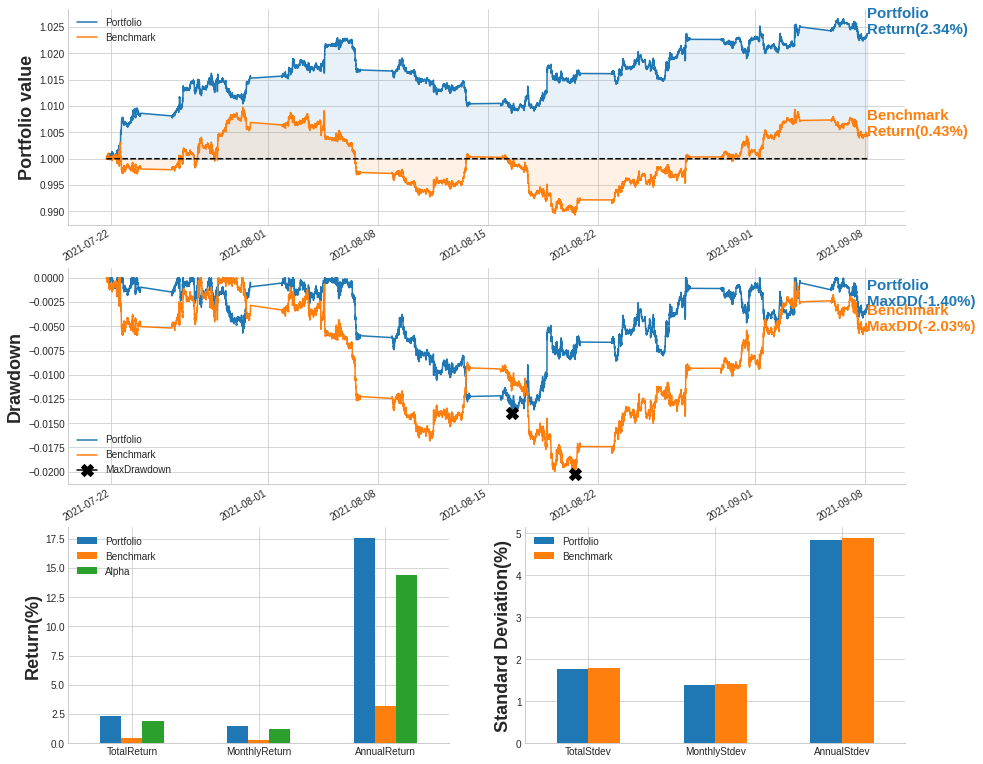

----------------------------------------------------------------------
Data length: |48 days 11:20:00|
Data range from |2021-07-21 16:40:00| to |2021-09-08 04:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       2.339 │       0.427 │   1.912 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       1.447 │       0.264 │   1.183 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      17.610 │       3.212 │  14.398 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [9]:
backtest.results()